### **TENSORFLOW DATASET**

In [2]:
# coding=utf-8
# Copyright 2024 The TensorFlow Datasets Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Cats vs Dogs dataset."""

import io
import re
import zipfile

from absl import logging
from tensorflow_datasets.core.utils.lazy_imports_utils import tensorflow as tf
import tensorflow_datasets.public_api as tfds

_CITATION = """\
@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
year = {2007},
month = {October},
publisher = {Association for Computing Machinery, Inc.},
url = {https://www.microsoft.com/en-us/research/publication/asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization/},
edition = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
}
"""

_URL = (
    "https://download.microsoft.com/download/3/E/1/"
    "3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
)
_NUM_CORRUPT_IMAGES = 1738
_DESCRIPTION = (
    "A large set of images of cats and dogs. "
    "There are %d corrupted images that are dropped." % _NUM_CORRUPT_IMAGES
)

_NAME_RE = re.compile(r"^PetImages[\\/](Cat|Dog)[\\/]\d+\.jpg$")


class CatsVsDogs(tfds.core.GeneratorBasedBuilder):
  """Cats vs Dogs."""

  VERSION = tfds.core.Version("4.0.1")
  RELEASE_NOTES = {
      "4.0.0": "New split API (https://tensorflow.org/datasets/splits)",
      "4.0.1": (
          "Recoding images in generator to fix corrupt JPEG data warnings"
          " (https://github.com/tensorflow/datasets/issues/2188)"
      ),
  }

  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        description=_DESCRIPTION,
        features=tfds.features.FeaturesDict({
            "image": tfds.features.Image(),
            "image/filename": tfds.features.Text(),  # eg 'PetImages/Dog/0.jpg'
            "label": tfds.features.ClassLabel(names=["cat", "dog"]),
        }),
        supervised_keys=("image", "label"),
        homepage=(
            "https://www.microsoft.com/en-us/download/details.aspx?id=54765"
        ),
        citation=_CITATION,
    )

  def _split_generators(self, dl_manager):
    path = dl_manager.download(_URL)

    # There is no predefined train/val/test split for this dataset.
    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs={
                "archive": dl_manager.iter_archive(path),
            },
        ),
    ]

  def _generate_examples(self, archive):
    """Generate Cats vs Dogs images and labels given a directory path."""
    num_skipped = 0
    for fname, fobj in archive:
      res = _NAME_RE.match(fname)
      if not res:  # README file, ...
        continue
      label = res.group(1).lower()
      if tf.compat.as_bytes("JFIF") not in fobj.peek(10):
        num_skipped += 1
        continue

      # Some images caused 'Corrupt JPEG data...' messages during training or
      # any other iteration recoding them once fixes the issue (discussion:
      # https://github.com/tensorflow/datasets/issues/2188).
      # Those messages are now displayed when generating the dataset instead.
      img_data = fobj.read()
      img_tensor = tf.image.decode_image(img_data)
      img_recoded = tf.io.encode_jpeg(img_tensor)

      # Converting the recoded image back into a zip file container.
      buffer = io.BytesIO()
      with zipfile.ZipFile(buffer, "w") as new_zip:
        new_zip.writestr(fname, img_recoded.numpy())
      new_fobj = zipfile.ZipFile(buffer).open(fname)

      record = {
          "image": new_fobj,
          "image/filename": fname,
          "label": label,
      }
      yield fname, record

    if num_skipped != _NUM_CORRUPT_IMAGES:
      raise ValueError(
          "Expected %d corrupt images, but found %d"
          % (_NUM_CORRUPT_IMAGES, num_skipped)
      )
    logging.warning("%d images were corrupted and were skipped", num_skipped)

### **SVM FOR DOG VS CAT**

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


In [5]:

# Load the Cats vs Dogs dataset
dataset, info = tfds.load('cats_vs_dogs', split='train', with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteKWCJ5W/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [6]:
# Function to preprocess the dataset
def preprocess(example):
    image = tf.image.resize(example['image'], (100, 100))  # Resize images to a fixed size
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    label = tf.cast(example['label'], tf.int32)  # Convert labels to integers (0 for cats, 1 for dogs)
    return image, label



In [7]:
# Preprocess the dataset and split it into training and testing sets
batch_size = 32
train_dataset = dataset.map(preprocess).batch(batch_size)
X_train, y_train = next(iter(train_dataset))
X_train, X_test, y_train, y_test = train_test_split(X_train.numpy(), y_train.numpy(), test_size=0.2, random_state=42)



In [8]:
# Flatten images
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)



In [9]:
# Create and train the SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)


SVC(kernel='linear')

In [10]:
# Make predictions on the testing set
y_pred = svm_model.predict(X_test)


In [11]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7142857142857143


### **PREDICTIONS**

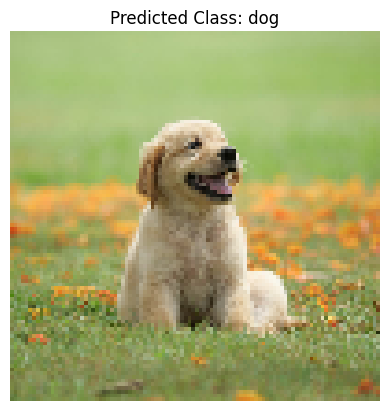

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (100, 100))
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Path to the test image
test_image_path = '/content/doggy.jpg'

# Load and preprocess the test image
test_image = load_and_preprocess_image(test_image_path)

# Reshape the image to match the input format expected by the SVM model
test_image = np.array(test_image).reshape(1, -1)

# Make prediction using the trained SVM model
prediction = svm_model.predict(test_image)

# Convert the prediction label to human-readable format
class_label = 'dog' if prediction[0] == 1 else 'cat'

# Display the test image
plt.imshow(test_image.reshape(100, 100, 3))
plt.title(f'Predicted Class: {class_label}')
plt.axis('off')
plt.show()
